# Module 02_02: KNN: targeting CPU and Patching 

![Assets/KNNacceleration.jpg](Assets/KNNacceleration.jpg)
### Use nbconvert  patch_sklearn from command line

# Learning Objectives:

1) Describe how to surgically unpatch specific optimized functions if needed
1) Apply patching to KNN algorithm
2) Describe acceleration for the covtype dataset with KNN classification



# *Real World* example KNN on CovType Dataset

### Compare timings of stock kmeans versus Intel Extension for Scikit-learn KNN using patch_sklean()

Below we will apply Intel Extension for Scikit learn to a use case on a CPU

Intel® Extension for Scikit-learn contains drop-in replacement functionality for the stock scikit-learn package. You can take advantage of the performance optimizations of Intel Extension for Scikit-learn by adding just two lines of code before the usual scikit-learn imports. Intel® Extension for Scikit-learn patching affects performance of specific Scikit-learn functionality.

### Data: covtype

We will use forest cover type dataset known as covtype and fetch the data from sklearn.datasets


Here we are **predicting forest cover type** from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.


Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

### Overview of procedure
In the below example we will train and predict kNN algorithm with Intel Extension for Scikit-learn for covtype dataset and calculate the CPU and wall clock time for training and prediction. Then in the next step we will unpatch the Intel extension for Scikit-learn and observe the time taken on the CPU for the same trainng and prediction.

### Fetch the Data

- [Back to Sections](#Back_to_Sections)


In [6]:
# Copyright 2022 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import pandas as pd
import seaborn as sns
import time

from  sklearn.datasets import fetch_covtype
x, y = fetch_covtype(return_X_y=True)
# Data Set Information:
# Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).
# This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

# for sake of time is 1/4th of the data
subset = x.shape[0]//4
x = x[:subset,:]
y = y[:subset]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=72)

# set up KNN algorithm parameters
# 'n_neighbors': 40,  
#     regulates how many neighbors should be checked when an item is being classified
# 'weights': 'distance',
#     signifies how weight should be distributed between neighbor values.
#     This value will cause weights to be distributed based on their distance (inversely correlated). Closer neighbors will have a higher weight in the algorithm.
# 'n_jobs': -1
#     Signifies the parallel jobs to be allowed at the same time for neighbor algorithm
params = {
    'n_neighbors': 40,  
    'weights': 'distance',  
    'n_jobs': -1
}
print('dataset shape: ', x.shape)

dataset shape:  (145253, 54)


### Show patched KNN


- [Back to Sections](#Back_to_Sections)

# Exercise: Apply patch

In [7]:
# Copyright 2022 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


################# Insert Patch here ####################################
from sklearnex import patch_sklearn
patch_sklearn()
########################################################################


from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
knn = KNeighborsClassifier(**params).fit(x_train, y_train)
predicted = knn.predict(x_test)
patched_time = time.time() - start_time
print("Time to calculate \033[1m knn.predict in Patched scikit-learn {:4.1f}\033[0m seconds".format(patched_time))

report = metrics.classification_report(y_test, predicted)
print(f"Classification report for kNN:\n{report}\n")


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Time to calculate  knn.predict in Patched scikit-learn  1.5 seconds
Classification report for kNN:
              precision    recall  f1-score   support

           1       0.93      0.86      0.89      6120
           2       0.94      0.98      0.96     20540
           3       0.84      0.46      0.60       428
           4       0.84      0.95      0.89       441
           5       0.86      0.64      0.73       631
           6       0.80      0.58      0.67       449
           7       0.84      0.87      0.85       442

    accuracy                           0.93     29051
   macro avg       0.86      0.76      0.80     29051
weighted avg       0.93      0.93      0.93     29051




In order to cancel optimizations, we use unpatch_sklearn and reimport the class KNeighborsClassifier. Observe the time taken to train and predict without the optimizations. 

### Show UNpatched KNN


- [Back to Sections](#Back_to_Sections)

# Exercise: Apply UNpatch


In [8]:
# Copyright 2022 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#########################################
#
# Insert unpatch code here
from sklearnex import unpatch_sklearn
unpatch_sklearn()
#
#########################################

# same code used to predict as from above cell - but this one is UNPATCHED
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
knn = KNeighborsClassifier(**params).fit(x_train, y_train)
predicted = knn.predict(x_test)
unpatched_time = time.time() - start_time
print("Time to calculate \033[1m knn.predict in UNpatched scikit-learn {:4.1f}\033[0m seconds".format(patched_time))

report = metrics.classification_report(y_test, predicted)
print(f"Classification report for kNN:\n{report}\n")

Time to calculate  knn.predict in UNpatched scikit-learn  1.5 seconds
Classification report for kNN:
              precision    recall  f1-score   support

           1       0.93      0.86      0.89      6120
           2       0.94      0.98      0.96     20540
           3       0.84      0.46      0.60       428
           4       0.84      0.95      0.89       441
           5       0.86      0.64      0.73       631
           6       0.80      0.58      0.67       449
           7       0.84      0.87      0.85       442

    accuracy                           0.93     29051
   macro avg       0.86      0.76      0.80     29051
weighted avg       0.93      0.93      0.93     29051




## Plot KNN speed up using patch


- [Back to Sections](#Back_to_Sections)


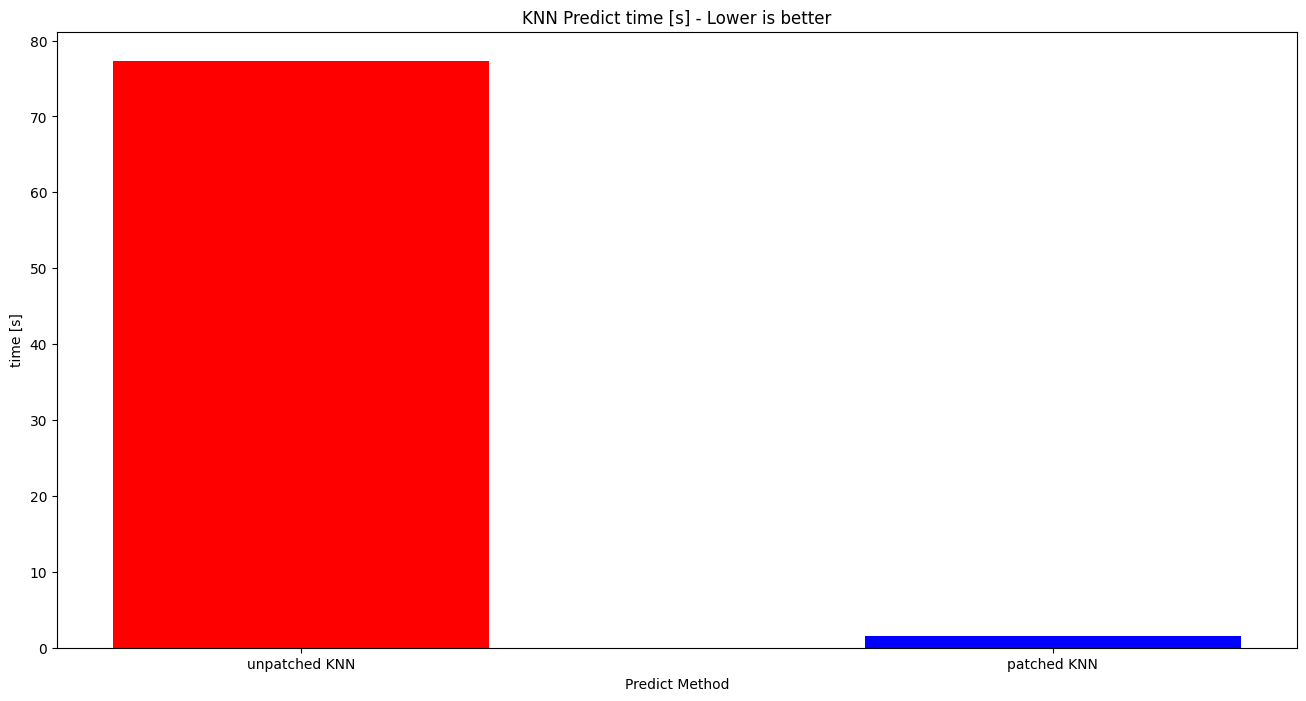

Intel(R) Extensions for scikit-learn* KNN acceleration 51.9 x!


In [9]:
# Copyright 2022 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
%matplotlib inline
import matplotlib.pyplot as plt

left = [1,2]
pred_times = [unpatched_time, patched_time]
tick_label = ['unpatched KNN', 'patched KNN']
plt.figure(figsize = (16,8))
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.xlabel('Predict Method'); plt.ylabel('time [s]'); plt.title('KNN Predict time [s] - Lower is better')
plt.show()

print('Intel(R) Extensions for scikit-learn* \033[1mKNN acceleration {:4.1f} x!\033[0m'.format( unpatched_time/patched_time))

## Observations:

We observe that with scikit-learn-intelex patching you can:

- Opimize performance with minimal changes (a couple of lines of code);
- Achieve faster execution with 32 opitmized sklearn algorithms
- Achieve the same model quality.

Compare the times and accuracies of these two runs. 

Is the time versus accuracy trade off worth the effort to patch this function?

Reminder of how to find the list of functions available to patch


# Summary:

You have:

1) applied patching to KNN algorithm
2) Describe acceleration for the covtype dataset
    

# Notices & Disclaimers 

Intel technologies may require enabled hardware, software or service activation.
No product or component can be absolutely secure.

Your costs and results may vary.

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
*Other names and brands may be claimed as the property of others.

In [10]:
print("All Done")

All Done
